Load the RDF data dump

In [1]:
%%time
from rdflib import ConjunctiveGraph

ns = {"nb": "http://bise-eu.info/core-ontology#",
      "dc": "http://dcterms/",
      "p-plan": "http://purl.org/net/p-plan#",
      "edam": "http://purl.obolibrary.org/obo/edam#"}

g = ConjunctiveGraph()
#g.parse("bise-linked-data-webapp/static/data/neubias-dump-20180129.ttl", format="turtle")
#g.parse("data-dumps/latest/neubias-latest.ttl", format="turtle")

### latest version of the RDF dataset dump
g.parse("https://github.com/NeuBIAS/bise-core-ontology/raw/master/data-dumps/latest/neubias-latest.ttl", format="turtle")
g.parse("bise-linked-data-webapp/static/data/EDAM-bioimaging_alpha03.owl")
print(str(len(g)) + ' triples in Biii data graph')

14494 triples in Biii data graph
CPU times: user 1.25 s, sys: 229 ms, total: 1.48 s
Wall time: 2.79 s


# Critical Entries +++

In [2]:
%%time
# Entries without authors and without download link
q = """
SELECT (count(?s) as ?nb_soft) WHERE {
    ?s rdf:type <http://biii.eu/node/software> .
    FILTER ( NOT EXISTS {?s nb:hasAuthor ?author} 
          && NOT EXISTS {?s nb:hasLocation ?location} ).
}
"""
no_authors_no_link = ""
results = g.query(q, initNs=ns)
for r in results:
    print('No author and no download link: ' + str(r["nb_soft"]))
    no_authors_no_link = r["nb_soft"]

    
# Entries with missing authors or download link
q = """
SELECT (count(?s) as ?nb_soft) WHERE {
    ?s rdf:type <http://biii.eu/node/software> .
    FILTER ( NOT EXISTS {?s nb:hasAuthor ?author} 
          || NOT EXISTS {?s nb:hasLocation ?location} ).
}
"""
no_authors_no_link = ""
results = g.query(q, initNs=ns)
for r in results:
    print('Missing authors or download link: ' + str(r["nb_soft"]))
    no_authors_no_link = r["nb_soft"]
    

# Entries without any EDAM operation
q = """
SELECT (count(?s) as ?nb_soft) WHERE {
    ?s rdf:type <http://biii.eu/node/software> .
    FILTER ( NOT EXISTS {?s nb:hasFunction ?function} 
          && NOT EXISTS {?s nb:hasTopic ?topic} ).
}
"""
no_EDAM = ""
results = g.query(q, initNs=ns)
for r in results:
    print('No EDAM annotations: ' + str(r["nb_soft"]))
    no_EDAM = r["nb_soft"]

    
# Entries without license
q = """
SELECT (count(?s) as ?nb_soft) WHERE {
    ?s rdf:type <http://biii.eu/node/software> .
    FILTER ( NOT EXISTS {?s nb:hasLicense ?license} ).
}
"""
no_License = ""
results = g.query(q, initNs=ns)
for r in results:
    print('No License (free text): ' + str(r["nb_soft"]))
    no_License = r["nb_soft"]

No author and no download link: 72
Missing authors or download link: 823
No EDAM annotations: 867
No License (free text): 1326
CPU times: user 2.84 s, sys: 27.5 ms, total: 2.87 s
Wall time: 2.89 s


In [3]:
%%time
q = """
SELECT ?label (count(distinct ?s1) as ?soft_count) WHERE { 
    ?s1 a <http://biii.eu/node/software> .
    ?s1 <http://bise-eu.info/core-ontology#hasTopic> ?edam_class .
    ?edam_class rdfs:label ?label
}
GROUP BY ?edam_class ?label
ORDER BY DESC(?soft_count)
"""

results = g.query(q, initNs=ns)

for r in results:
    print (r["label"] + " : " + r["soft_count"])

Bioimage informatics : 81
Fluorescence microscopy : 56
Machine learning : 36
Digital histology : 28
Microscopy : 23
Electron microscopy : 17
Light-sheet microscopy : 17
Imaging : 16
High content screening : 15
Statistics : 15
Confocal microscopy : 14
Super-resolution microscopy : 14
Light microscopy : 13
Single molecule localization microscopy : 12
Data sharing : 11
Bright field microscopy : 10
Confocal fluorescence microscopy : 10
Phase contrast microscopy : 8
Magnetic resonance imaging : 6
Widefield microscopy : 5
Structured illumination microscopy : 5
Tomography : 4
Correlative Light and Electron Microscopy : 4
In-silico reconstruction : 3
Computerized tomography : 3
Topic : 3
Live sample imaging : 3
Electron tomography : 2
Multi-photon microscopy : 2
Spectroscopy : 2
Scanning electron microscopy : 2
Focused ion beam scanning electron microscopy : 1
Image correlation spectroscopy : 1
Fluctuation based microscopy : 1
In-vitro imaging : 1
Cryo electron tomography : 1
Fluorescence life

## Count the number of tools without any reference publication

In [4]:
%time
no_doi_query = """
SELECT ?s (count(?title) as ?nb_soft) WHERE {
    ?s rdf:type <http://biii.eu/node/software> .
    ?s dc:title ?title .
    FILTER NOT EXISTS {?s nb:hasReferencePublication ?publication} .
}
"""
results = g.query(no_doi_query, initNs=ns)
for r in results:
    print(r["nb_soft"])

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 5.01 µs
1072


## Count the number of tools with a reference publication

In [5]:
%%time
doi_query = """
SELECT ?s (count(?title) as ?nb_soft) WHERE {
    ?s rdf:type <http://biii.eu/node/software> .
    ?s dc:title ?title .
    ?s nb:hasReferencePublication ?publication .
}
"""
results = g.query(doi_query, initNs=ns)
for r in results:
    print(r["nb_soft"])

485
CPU times: user 98.6 ms, sys: 1.56 ms, total: 100 ms
Wall time: 99.4 ms


In [6]:
%%time
how_many_tools_per_topic = """
SELECT ?label (count(distinct ?s1) as ?soft_count) WHERE { 
    ?s1 a <http://biii.eu/node/software> .
    ?s1 <http://bise-eu.info/core-ontology#hasTopic> ?edam_class .
        
    ?edam_class rdfs:label ?label .
}
GROUP BY ?edam_class ?label
ORDER BY DESC(?soft_count)
"""

results = g.query(how_many_tools_per_topic, initNs=ns)
for r in results:
    print(r["label"] + " : " + r["soft_count"])

Bioimage informatics : 81
Fluorescence microscopy : 56
Machine learning : 36
Digital histology : 28
Microscopy : 23
Electron microscopy : 17
Light-sheet microscopy : 17
Imaging : 16
High content screening : 15
Statistics : 15
Confocal microscopy : 14
Super-resolution microscopy : 14
Light microscopy : 13
Single molecule localization microscopy : 12
Data sharing : 11
Bright field microscopy : 10
Confocal fluorescence microscopy : 10
Phase contrast microscopy : 8
Magnetic resonance imaging : 6
Widefield microscopy : 5
Structured illumination microscopy : 5
Tomography : 4
Correlative Light and Electron Microscopy : 4
In-silico reconstruction : 3
Computerized tomography : 3
Topic : 3
Live sample imaging : 3
Electron tomography : 2
Multi-photon microscopy : 2
Spectroscopy : 2
Scanning electron microscopy : 2
Focused ion beam scanning electron microscopy : 1
Image correlation spectroscopy : 1
Fluctuation based microscopy : 1
In-vitro imaging : 1
Cryo electron tomography : 1
Fluorescence life

In [7]:
%%time
how_many_tools_per_operation = """
SELECT ?label (count(distinct ?s1) as ?soft_count) WHERE { 
    ?s1 a <http://biii.eu/node/software> .
    ?s1 <http://bise-eu.info/core-ontology#hasFunction> ?edam_class .
        
    ?edam_class rdfs:label ?label .
}
GROUP BY ?edam_class ?label
ORDER BY DESC(?soft_count)
"""

results = g.query(how_many_tools_per_operation, initNs=ns)
for r in results:
    print(r["label"] + " : " + r["soft_count"])

Image segmentation : 75
Cell segmentation : 35
Image registration : 33
Object tracking : 33
Filament tracing : 32
Spot detection : 30
Visualisation : 30
Image analysis : 28
Image processing : 26
Analysis : 24
Image visualisation : 24
Neuron image analysis : 23
Morphological operation : 21
Image deconvolution : 19
Colocalisation analysis : 18
Object detection : 17
Shape features : 16
Object counting : 16
Image thresholding : 16
Cell tracking : 16
Volume rendering : 15
Affine registration : 14
Object feature extraction : 13
Isolated object classification : 13
Data handling : 13
Watershed : 13
Smoothing : 13
Interactive segmentation : 12
Rigid registration : 12
Image enhancement : 11
Pixel classification : 11
Object-based colocalisation : 11
Active contours : 10
Image annotation : 10
Image denoising : 9
Deformable registration : 9
Image correction : 9
Isolated object detection : 9
Particle tracking : 8
Affine : 7
Skeletonisation : 7
Alignment construction : 7
Image stitching : 7
Chromatic

# Count the number of tool for 2018

In [65]:
%%time
date_query = """
SELECT (count(?soft) as ?nb_soft) WHERE {
    ?soft a <http://biii.eu/node/software> .
    ?soft dc:created ?date .
    FILTER ((?date > "2018-01-01T00:00:00"^^xsd:dateTime) 
            && (?date < "2019-01-01T00:00:00"^^xsd:dateTime))
}
"""
results = g.query(date_query, initNs=ns)
for r in results:
    print('{} registered softwares in 2018'.format(r['nb_soft']))
#    print(r["label"] + " : " + r["soft_count"])
print()


169 registered softwares in 2018

CPU times: user 306 ms, sys: 2.46 ms, total: 308 ms
Wall time: 307 ms


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

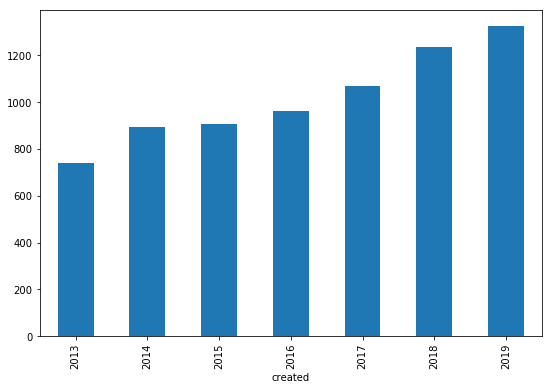

In [10]:
%matplotlib inline

#plt.figure(figsize=(16, 10))
plt.figure(figsize=(9, 6))

soft_dates = []
date_query = """
SELECT ?soft ?date WHERE {
    ?soft a <http://biii.eu/node/software> .
    ?soft dc:created ?date .
}
"""
results = g.query(date_query, initNs=ns)
for r in results:
    soft_dates.append({'soft':r['soft'], 'created':r['date']})

df = pd.DataFrame(soft_dates)
df["created"] = df["created"].astype("datetime64")

#df2 = df.groupby([df["created"].dt.year, df["created"].dt.month]).count()
df2 = df.groupby([df["created"].dt.year]).count()

df2['soft'].cumsum().plot(kind='bar')

In [27]:
import seaborn as sns


per_year_df = df.groupby([df["created"].dt.year]).count()[['soft']]
per_year_df.to_csv('counts_per_year.csv')
per_year_df

#sns.countplot(per_year_df['soft'])

,soft
created,
2013,740
2014,152
2015,14
2016,54
2017,107
2018,169
2019,90


Ideas of plots : 
 - cumulative stacked hostogram with : "no EDAM annotation" / "some EDAM annotatino" to show that we improvve the quality of tool descriptions
 - same thing with 4-5 categories for the main Topics
 - same thing Tools VS Traing material
 - Open Source VS Comercial softwares 
 

In [41]:
#%%time
#get the main Topics
how_many_tools_per_topic = """
SELECT ?l (count(distinct ?s1) as ?soft_count) WHERE { 
#SELECT ?subclass WHERE { 
    ?s1 a <http://biii.eu/node/software> .
    ?c rdfs:subClassOf <http://edamontology.org/topic_0003> .
    ?c rdfs:label ?l .
    ?subclass rdfs:subClassOf* ?c .
    ?s1 <http://bise-eu.info/core-ontology#hasTopic> ?subclass .
}
GROUP BY ?c ?l
ORDER BY DESC(?soft_count)
"""

list_of_topics = []
results = g.query(how_many_tools_per_topic, initNs=ns)
for r in results:
    list_of_topics.append({'Topic':str(r['l']), 'Count':str(r['soft_count'])})   
#print(list_of_topics)

df = pd.DataFrame(list_of_topics)
df

[{'Topic': 'Imaging', 'Count': '177'}, {'Topic': 'Bioimage informatics', 'Count': '81'}, {'Topic': 'Machine learning', 'Count': '36'}, {'Topic': 'Digital histology', 'Count': '28'}, {'Topic': 'Statistics', 'Count': '15'}, {'Topic': 'High content screening', 'Count': '15'}, {'Topic': 'Data sharing', 'Count': '11'}, {'Topic': 'In-silico reconstruction', 'Count': '3'}]


,Count,Topic
0,177,Imaging
1,81,Bioimage informatics
2,36,Machine learning
3,28,Digital histology
4,15,Statistics
5,15,High content screening
6,11,Data sharing
7,3,In-silico reconstruction


In [42]:
#%%time
#get the main Operations
how_many_tools_per_op = """
SELECT ?l (count(distinct ?s1) as ?soft_count) WHERE { 
#SELECT ?subclass ?l WHERE { 
    ?s1 a <http://biii.eu/node/software> .
    ?c rdfs:subClassOf <http://edamontology.org/operation_0004> .
    ?c rdfs:label ?l .
    ?subclass rdfs:subClassOf* ?c .
    ?s1 <http://bise-eu.info/core-ontology#hasFunction> ?subclass .
}
GROUP BY ?c ?l
ORDER BY DESC(?soft_count)
"""

list_of_op = []
results = g.query(how_many_tools_per_op, initNs=ns)
for r in results:
    list_of_op.append({'Operation':str(r['l']), 'Count':str(r['soft_count'])})

df = pd.DataFrame(list_of_op)
df

,Count,Operation
0,282,Analysis
1,169,Image processing
2,52,Visualisation
3,50,Generation
4,44,Alignment construction
5,32,Classification
6,16,Data handling
7,13,Annotation
8,9,Prediction and recognition
9,4,Clustering


In [46]:
#%%time
list_tools_op_topic = """
SELECT ?s1 ?ol ?tl WHERE { 
    ?s1 a <http://biii.eu/node/software> .
    ?oc rdfs:subClassOf <http://edamontology.org/operation_0004> .
    ?oc rdfs:label ?ol .
    ?osc rdfs:subClassOf* ?oc .
    ?s1 <http://bise-eu.info/core-ontology#hasFunction> ?osc .
    
    ?tc rdfs:subClassOf <http://edamontology.org/topic_0003> .
    ?tc rdfs:label ?tl .
    ?tsc rdfs:subClassOf* ?tc .
    ?s1 <http://bise-eu.info/core-ontology#hasTopic> ?tsc .
}
"""
tools = []
results = g.query(list_tools_op_topic, initNs=ns)
for r in results:
    t = {'tool':str(r['s1']), 'operation': str(r['ol']),'topic': str(r['tl'])}
    #print(t)
    tools.append(t)

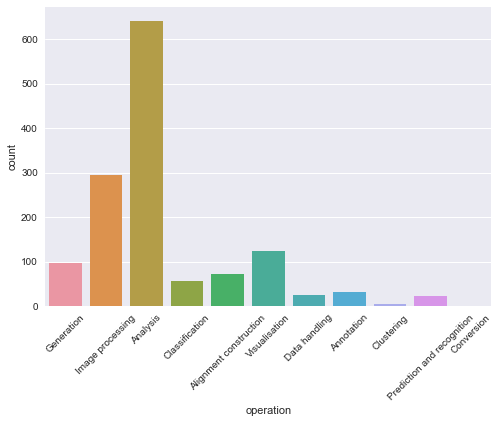

In [47]:
df = pd.DataFrame(tools)
chart = sns.countplot(x="operation", data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

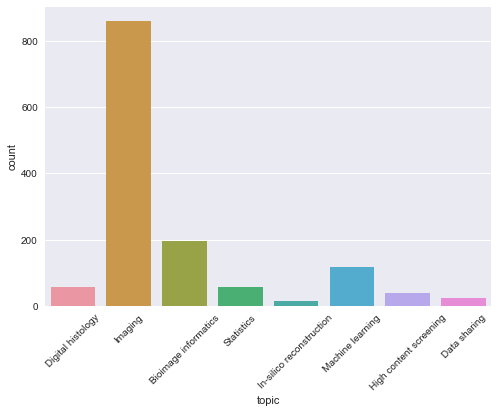

In [48]:
df = pd.DataFrame(tools)
chart = sns.countplot(x="topic", data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

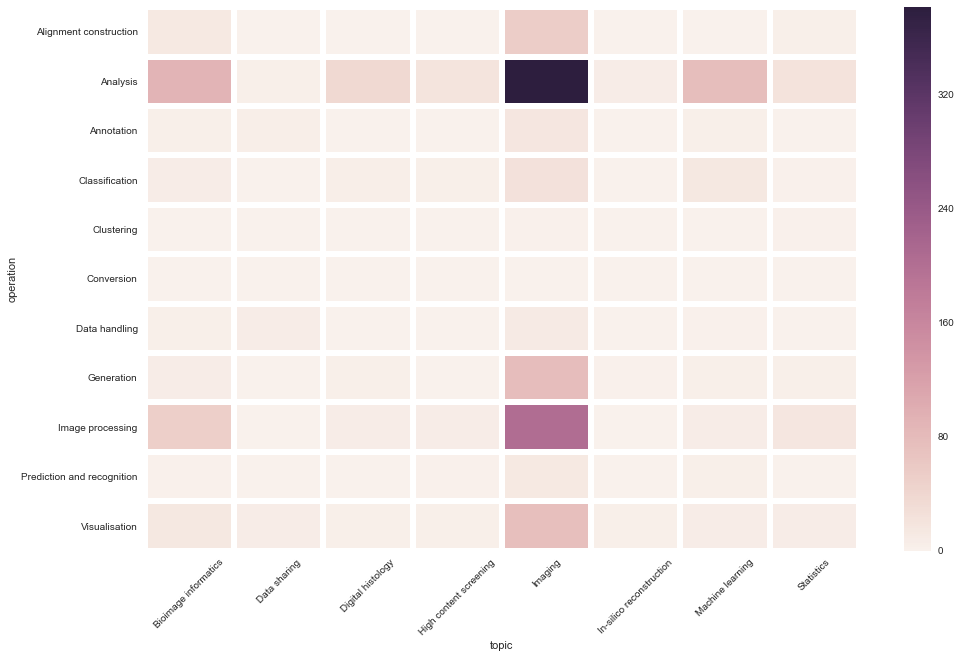

In [61]:
plt.figure(figsize=(16, 10))

df_heatmap = pd.DataFrame(tools) 
df_heatmap
df_heatmap_dum = pd.get_dummies(df_heatmap, columns=['operation', 'topic'])
df_heatmap_dum

df_crosstab = pd.crosstab(df_heatmap['operation'], df_heatmap['topic'])
#df_heatmap_dum.corr()
#sns.heatmap(df_heatmap_dum.corr(), linewidths=.5)
#corr = df_heatmap['operation'].corr(df_heatmap['topic'])
#corr
#sns.heatmap(df_heatmap.corr(), linewidths=.5)
chart = sns.heatmap(df_crosstab, linewidths=5)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)